#### imports etc.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
%matplotlib inline
sns.set_style("darkgrid")
train = pd.read_csv('train.csv')

Look at the shape of the data.

In [2]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Just out of curiosity, let's see what happened to the family of 8.

In [3]:
largefam = train[train['SibSp']==8]
largefam['Survived'] # :-(

159    0
180    0
201    0
324    0
792    0
846    0
863    0
Name: Survived, dtype: int64

Look at the features in the dataset.

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Observations:
- *Survived* is target variable.
- *Pclass, Sex, Age, SibSp, Parch, Fare* look like interesting numeric/categorical features that may have predictive value.
- We'll assume that *PassengerId, Name, Ticket* do not hold any predictive information correlated with survival.
- *Embarked* worth exploring further, perhaps creating dummy variables.
- *Cabin* looks like it may hold lots of missing data - let's check this first.

In [5]:
len(train[train.Cabin.isnull()])

687

Ignore *Cabin* for now and proceed with other variables. Let's first see the extent of the missing data.

In [6]:
interesting_features = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']
train[interesting_features].count()

Pclass      891
Sex         891
Age         714
SibSp       891
Parch       891
Fare        891
Embarked    889
dtype: int64

Only *Age* has many missing values; *Embarked* has 2 missing values.

For *Embarked* I will just fill in the 2 missing values with whatever the most common value is.

In [7]:
pd.pivot_table(train,values='PassengerId',index='Embarked',aggfunc=('count'))

Embarked
C    168
Q     77
S    644
Name: PassengerId, dtype: int64

In [8]:
train['Embarked'] = train['Embarked'].fillna('S')

We'll also convert *Embarked* to numeric values, so that *S* = 0, *C* = 1, *Q* = 77.

In [9]:
train.loc[train['Embarked']=='S','Embarked'] = 0
train.loc[train['Embarked']=='C','Embarked'] = 1
train.loc[train['Embarked']=='Q','Embarked'] = 2
train['Embarked'] = pd.to_numeric(train['Embarked'])

For the missing *Age* values I will input the average age for passengers with the same *Sex* and *Class*.

In [10]:
train['Age'] = train.groupby(["Sex", 'Pclass']).Age.transform(lambda x: x.fillna(x.mean()))

Next I will convert the *Sex* string values (male/female) to 0/1 boolean values.

In [11]:
train.loc[train['Sex']=='male','Sex'] = 0
train.loc[train['Sex']=='female','Sex'] = 1
train['Sex'] = pd.to_numeric(train['Sex'])

Dummy the *Pclass* values.

In [12]:
train = train.join(pd.get_dummies(train.Pclass, prefix='Pclass'))

For the counts of parents/children and siblings/spouses I will simplify these to binary columns of *had_Parch* and *had_SibSp*.

In [13]:
train['had_Parch'] = train.Parch.apply(lambda x: 1 if x > 0 else 0)
train['had_SibSp'] = train.SibSp.apply(lambda x: 1 if x > 0 else 0)

Now let's look at the final dataframe of our interesting features for analysis.

In [14]:
train.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3,had_Parch,had_SibSp
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.25,NaN,0,0.0,0.0,1.0,0,1


## Data cleansing finished, now to explore the features

Anecdotally there is a belief that passengers of lower class were more likely to die - let's see if this is accurate.

In [16]:
for i in ['Pclass_1','Pclass_2','Pclass_3']:
    print i,'%', round(train[train[i]==1]['Survived'].mean()*100,1), 'survived'

 Pclass_1 % 63.0 survived
Pclass_2 % 47.3 survived
Pclass_3 % 24.2 survived


Observations:
* Survival rate decreases with class 
* Only passengers in 1st class had more survivors than victims.
* 3rd class passengers survival rate just above 1/3 that of 1st class

Passenger class looks like it will be a good predictive feature for the model.

Next we'll look at Age and Gender to see if it was really "women and children first" onto the lifeboats.

In [17]:
print 'Oldest passenger',train.Age.max()
print 'Youngest passenger',train.Age.min()

Oldest passenger 80.0
Youngest passenger 0.42


Plot survival rate within 5-year age bins.

In [18]:
train['Age_bin'] = pd.cut(train.Age,range(0,85,5))
pd.pivot_table(data=train,values='Survived',index='Age_bin',aggfunc=('mean','count'))

,mean,count
Age_bin,,
"(0, 5]",0.704545,44
"(5, 10]",0.350000,20
"(10, 15]",0.578947,19
"(15, 20]",0.343750,96
"(20, 25]",0.408537,164
"(25, 30]",0.259804,204
"(30, 35]",0.490566,106
"(35, 40]",0.417910,67
"(40, 45]",0.323529,68


Not much of a pattern emerging; try larger age bins.

In [19]:
train['Age_bin'] = pd.cut(train.Age,range(0,85,10))
pd.pivot_table(data=train,values='Survived',index='Age_bin',aggfunc=('mean','count'))

,mean,count
Age_bin,,
"(0, 10]",0.593750,64
"(10, 20]",0.382609,115
"(20, 30]",0.326087,368
"(30, 40]",0.462428,173
"(40, 50]",0.355140,107
"(50, 60]",0.404762,42
"(60, 70]",0.235294,17
"(70, 80]",0.200000,5


In [20]:
train['Age_bin'] = pd.cut(train.Age,range(0,100,20))
pd.pivot_table(data=train,values='Survived',index='Age_bin',aggfunc=('mean','count'))

,mean,count
Age_bin,,
"(0, 20]",0.458101,179
"(20, 40]",0.369686,541
"(40, 60]",0.369128,149
"(60, 80]",0.227273,22


20-year age bins look quite predictive - 45% survival rate for under 20 year olds, compared to 22% for over 60 year olds. We'll create dummy columns from these age bins to add into the model.

In [21]:
train = train.join(pd.get_dummies(train.Age_bin, prefix='Age'))

Look at *Sex*.

In [22]:
pd.pivot_table(data=train,values='Survived',index='Sex',aggfunc=('mean','count'))

,mean,count
Sex,,
0,0.188908,577
1,0.742038,314


Looks like a very good feature for the model - males (0) have a much lower survival rate. We'll use this feature to create a baseline 1-feature model to build from.

#### What about the *Fare* passengers paid for their ticket?

Look at the distribution of fares.

(array([ 515.,  200.,   54.,   46.,   23.,   11.,   11.,    9.,    2.,
           0.,    4.,    5.,    2.,    6.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.]),
 array([  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240,
        260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500]),
 <a list of 25 Patch objects>)

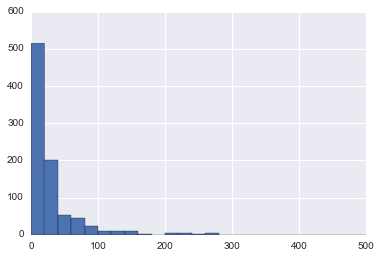

In [23]:
plt.hist(train.Fare,bins=range(0,514,20))

Look at the survival for those who paid up to the median fare, compared to those who paid over it.

In [24]:
train['Fare_bin'] = pd.cut(train.Fare,(-1,round(train.Fare.median()+1,0),round(train.Fare.max()+1,0)))
pd.pivot_table(data=train,values='Survived',index='Fare_bin',aggfunc=('mean','count'))

,mean,count
Fare_bin,,
"(-1, 15]",0.248908,458
"(15, 513]",0.526559,433


Looks like a good predictor - let's dummy the *Fare_bin* column for the model.

In [25]:
train = train.join(pd.get_dummies(train.Fare_bin,prefix='Fare_bin'))

#### What about where the passengers *Embarked*?

In [26]:
pd.pivot_table(data=train,values='Survived',index='Embarked',aggfunc=('mean','count'))

,mean,count
Embarked,,
0,0.339009,646
1,0.553571,168
2,0.389610,77


Looks like a good predictive feature, as survival rate for *Embarked* = 1 is much higher. Add the dummy columns to dataframe.

In [27]:
train = train.join(pd.get_dummies(train.Embarked,prefix='Embarked'))

#### Finally let's look at the *had_Parch* and *had_SibSp* features to see if travelling alone or not had any effect on survival chances.

In [28]:
pd.pivot_table(data=train,values='Survived',index='had_Parch',aggfunc=('mean','count'))

,mean,count
had_Parch,,
0,0.343658,678
1,0.511737,213


In [29]:
pd.pivot_table(data=train,values='Survived',index='had_SibSp',aggfunc=('mean','count'))

,mean,count
had_SibSp,,
0,0.345395,608
1,0.466431,283


Both look like good features as in both cases those with either parents/children or siblings/spouse had a higher survival rate. Let's also combine into one boolean feature of *had_family*, and see the survival rate for this.

In [43]:
train['had_family'] = train[['had_Parch','had_SibSp']].max(axis=1)

In [60]:
# plt.plot(train['had_Parch'].groupby(by=train.Survived).mean())
# plt.plot(train['had_SibSp'].groupby(by=train.Survived).mean())
plt.bar(data = train['had_family'].groupby(by=train.Survived).mean())


TypeError: bar() takes at least 2 arguments (1 given)

In [41]:
# Final dataframe for model.
train.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,"Age_(20, 40]","Age_(40, 60]","Age_(60, 80]",Fare_bin,"Fare_bin_(-1, 15]","Fare_bin_(15, 513]",Embarked_0,Embarked_1,Embarked_2,had_family
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.25,...,1.0,0.0,0.0,"(-1, 15]",1.0,0.0,1.0,0.0,0.0,1


## Now let's build a model.

First we will read in the test data and perform the same data manipulations on the features as we did with the training set.

In [717]:
test_df = pd.read_csv('test.csv')

# Convert Embarked to numeric and create dummies.
test_df.loc[test_df['Embarked']=='S','Embarked'] = 0
test_df.loc[test_df['Embarked']=='C','Embarked'] = 1
test_df.loc[test_df['Embarked']=='Q','Embarked'] = 2
test_df['Embarked'] = pd.to_numeric(test_df['Embarked'])
test_df = test_df.join(pd.get_dummies(test_df.Embarked,prefix='Embarked'))

# Fill in missing Age values with average for Sex/Class
test_df['Age'] = test_df.groupby(['Sex', 'Pclass']).Age.transform(lambda x: x.fillna(x.mean()))

# Create Agebin features
test_df['Age_bin'] = pd.cut(test_df.Age,range(0,100,20))
test_df = test_df.join(pd.get_dummies(test_df.Age_bin, prefix='Age'))

# There is one missing 'Fare' value - fill this in with the mean value.
test_df['Fare'].fillna(test_df.Fare.mean(),inplace=True)

# Create Farebin features (using median & max from train data)
test_df['Fare_bin'] = pd.cut(test_df.Fare,(-1,round(train.Fare.median()+1,0),round(train.Fare.max()+1,0)))
test_df = test_df.join(pd.get_dummies(test_df.Fare_bin,prefix='Fare_bin'))

# Convert Sex to binary values
test_df.loc[test_df['Sex']=='male','Sex'] = 0
test_df.loc[test_df['Sex']=='female','Sex'] = 1
test_df['Sex'] = pd.to_numeric(test_df['Sex'])

# Dummy Pclass feature
test_df = test_df.join(pd.get_dummies(test_df.Pclass, prefix='Pclass'))

# Convert Parch/Sibsp features to binary values
test_df['had_Parch'] = test_df.Parch.apply(lambda x: 1 if x > 0 else 0)
test_df['had_SibSp'] = test_df.SibSp.apply(lambda x: 1 if x > 0 else 0)

test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,"Age_(40, 60]","Age_(60, 80]",Fare_bin,"Fare_bin_(-1, 15]","Fare_bin_(15, 513]",Pclass_1,Pclass_2,Pclass_3,had_Parch,had_SibSp
0,892,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,...,0.0,0.0,"(-1, 15]",1.0,0.0,0.0,0.0,1.0,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,...,1.0,0.0,"(-1, 15]",1.0,0.0,0.0,0.0,1.0,0,1
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,...,0.0,1.0,"(-1, 15]",1.0,0.0,0.0,1.0,0.0,0,0
3,895,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,...,0.0,0.0,"(-1, 15]",1.0,0.0,0.0,0.0,1.0,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,...,0.0,0.0,"(-1, 15]",1.0,0.0,0.0,0.0,1.0,1,1


#### First let's plot the correlations of all features to see if there's any potential for multi-collinearity.

Axes(0.125,0.125;0.62x0.775)


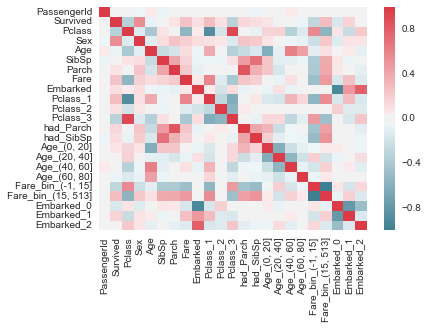

In [708]:
colour_map = sns.diverging_palette(220, 10, as_cmap=True)
correlations = train.corr()
print sns.heatmap(correlations,cmap=colour_map)

Observations:

- As might be expected, there is positive correlation between 1st class passengers and higher fare, and 3rd class passengers and lower fare - we should be cautious about including both in model.
- There is an interesting positive correlation between higher fares and travelling with parents/children/siblings/spouses. This might just be coincidence or maybe not - perhaps those travelling alone were less concerned with conditions. We'll need to explore the impact of including both features in model.
- We saw in the feature exploration that Embarked = 1 has a much higher survival rate than the other embarkation points, but now we see that this is also correlated with 1st class passengers; so we should be careful of using both features.

Begin with baseline logistic regression model for *Sex* ~ *Survived*.

In [732]:
lr = LogisticRegression()
X = train[['Sex']]
y = train['Survived']
lr.fit(X,y)
lr.predict(X)
print 'Accuracy of baseline model = ',lr.score(X, y)
print lr.coef_

Accuracy of baseline model =  0.786756453423
[[ 2.43070907]]


We'll use this baseline model to make predictions on the test data to submit on Kaggle, and then try and improve this score.

In [733]:
test_X = test_df[['Sex']]
predictions = lr.predict(test_X)
test_df['Survived'] = predictions
print 'Training bias =',df.Survived.mean()
print 'Test bias =',test_df.Survived.mean()
test_df[['PassengerId','Survived']].to_csv('titanic_baseline_submission.csv',header=True,index=False)

Training bias = 0.383838383838
Test bias = 0.363636363636


This submission scored 0.76555 accuracy and got to rank 4122 on the kaggle leaderboard.

Next I create a model with multiple features which intuitively I suspect might be good predictors for titanic disaster survival - namely *sex*, *class* and *age*.

In [777]:
lr = LogisticRegression()
X = train[['Sex','Pclass_1','Pclass_3','Age']] # Treating 2nd class as 'default' class level.
y = train['Survived']
lr.fit(X,y)
lr.predict(X)
print 'Accuracy = ',lr.score(X, y)
print lr.coef_
print lr

Accuracy =  0.794612794613
[[ 2.47215052  1.15631315 -1.24156929 -0.0362425 ]]
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Slightly better score with this model. Now see if we can improve this at all tuning the hyper-parameters using cross-validated grid-search.

In [783]:
from sklearn import grid_search, cross_validation
cvalues = np.logspace(-1,1,num=20)
gs = grid_search.GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={'penalty': ('l1','l2'),
               'fit_intercept':('True','False'),
               'C':cvalues},
    cv=cross_validation.KFold(n=len(df), n_folds=5),
    scoring='accuracy')
gs.fit(X, y)
print "Best score"
print gs.best_score_
print
print "Best estimator"
print gs.best_estimator_
print
print "Coefficients"
print gs.best_estimator_.coef_

Best score
0.796857463524

Best estimator
LogisticRegression(C=0.10000000000000001, class_weight=None, dual=False,
          fit_intercept='True', intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Coefficients
[[ 1.91669005  0.85666597 -1.00110018 -0.03026919]]


See if this model scores better on kaggle.

In [784]:
test_X = test_df[['Sex','Pclass_1','Pclass_3','Age']]
predictions = gs.best_estimator_.predict(test_X)
test_df['Survived'] = predictions
print 'Training bias =',df.Survived.mean()
print 'Test bias =',test_df.Survived.mean()
test_df[['PassengerId','Survived']].to_csv('titanic_optimised_submission.csv',header=True,index=False)

Training bias = 0.383838383838
Test bias = 0.354066985646


This model scored worse! Kaggle submission score of 0.75598

# TO BE CONTINUED

In [729]:
test_X = test_df[['Sex']]
predictions = gs.best_estimator_.predict(test_X)
test_df['Survived'] = predictions
print 'Training bias =',df.Survived.mean()
print 'Test bias =',test_df.Survived.mean()
test_df[['PassengerId','Survived']].to_csv('titanic_baseline_submission.csv',header=True,index=False)

Training bias = 0.383838383838
Test bias = 0.363636363636


In [731]:
lr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Now let's try adding in the continuous *Age* variable, comparing against a model which uses the *Age_bin* dummy variables, and seeing if either improves the kaggle score.

In [712]:
lr = LogisticRegression()
X = train[['Sex','Age']]
y = train['Survived']
lr.fit(X,y)
lr.predict(X)
print 'Accuracy of model with continuous age variable = ',lr.score(X, y)

Accuracy of model with continuous age variable =  0.786756453423


This model hasn't improved the score at all, it is identical to the baseline model. This must mean that the coefficient for the continuous *Age* variable is too small to change the predictions - let's look at the model's 2 coefficients.

In [713]:
lr.coef_

array([[ 2.42328472, -0.0031822 ]])

What if we use the dummy *Age_bins* instead?

In [714]:
lr = LogisticRegression()
X = train[['Sex','Age_(0, 20]','Age_(20, 40]','Age_(40, 60]']]
y = train['Survived']
lr.fit(X,y)
lr.predict(X)
print 'Accuracy of model with dummy age variables = ',lr.score(X, y)

Accuracy of model with dummy age variables =  0.786756453423


Still no difference - we'll ignore *Age* for now and try other features. We know that passenger class seems to be a strong predictor from our feature exploration.

In [720]:
lr = LogisticRegression()
X = train[['Sex','Pclass_3','Pclass_2']]
y = train['Survived']
lr.fit(X,y)
lr.predict(X)
print 'Accuracy of model with class variables = ',lr.score(X, y)
print 'Coefficients',lr.coef_

Accuracy of model with class variables =  0.786756453423
Coefficients [[ 2.53314241 -1.78769326 -0.74064995]]


In [718]:
test_X = test_df[['Sex','Pclass_3','Pclass_2','Fare']]
predictions = lr.predict(test_X)
test_df['Survived'] = predictions
print 'Training bias =',df.Survived.mean()
print 'Test bias =',test_df.Survived.mean()
test_df[['PassengerId','Survived']].to_csv('titanic_sex_class_age_submission.csv',header=True,index=False)

Training bias = 0.383838383838
Test bias = 0.368421052632


In [719]:
test_df.count()

PassengerId           418
Pclass                418
Name                  418
Sex                   418
Age                   418
SibSp                 418
Parch                 418
Ticket                418
Fare                  418
Cabin                  91
Embarked              418
Embarked_0            418
Embarked_1            418
Embarked_2            418
Age_bin               418
Age_(0, 20]           418
Age_(20, 40]          418
Age_(40, 60]          418
Age_(60, 80]          418
Fare_bin              418
Fare_bin_(-1, 15]     418
Fare_bin_(15, 513]    418
Pclass_1              418
Pclass_2              418
Pclass_3              418
had_Parch             418
had_SibSp             418
Survived              418
dtype: int64

In [686]:
lr = LogisticRegression()
X = train[['Sex','Fare_bin_(15, 513]']]
y = train['Survived']
lr.fit(X,y)
lr.predict(X)
print 'Accuracy of model with class variables = ',lr.score(X, y)
print lr.coef_

Accuracy of model with class variables =  0.786756453423
[[ 2.32109922  0.93452163]]


In [666]:
train.dtypes

PassengerId              int64
Survived                 int64
Pclass                   int64
Name                    object
Sex                      int64
Age                    float64
SibSp                    int64
Parch                    int64
Ticket                  object
Fare                   float64
Cabin                   object
Embarked                 int64
Pclass_1               float64
Pclass_2               float64
Pclass_3               float64
had_Parch                int64
had_SibSp                int64
Age_bin               category
Age_(0, 20]            float64
Age_(20, 40]           float64
Age_(40, 60]           float64
Age_(60, 80]           float64
Fare_bin              category
Fare_bin_(-1, 15]      float64
Fare_bin_(15, 513]     float64
Embarked_0             float64
Embarked_1             float64
Embarked_2             float64
dtype: object

In [658]:
test_X = test_df[['Sex','Age']]
predictions = lr.predict(test_X)
test_df['Survived'] = predictions
print 'Training bias =',df.Survived.mean()
print 'Test bias =',test_df.Survived.mean()
test_df[['PassengerId','Survived']].to_csv('titanic_baseline_plus_age_continuous_submission.csv',header=True,index=False)

Training bias = 0.383838383838
Test bias = 0.363636363636


In [527]:
X = df[['Sex','Pclass_1','Pclass_2','Pclass_3','had_Parch','had_SibSp','Age_(0, 20]','Age_(20, 40]',\
        'Age_(40, 60]','Age_(60, 80]','Fare_bin_(-1, 15]','Fare_bin_(15, 513]',\
       'Embarked_0','Embarked_1','Embarked_2']]
lr.fit(X,y)
lr.predict(X)
print lr.score(X, y)
print lr.coef_

0.801346801347
[[  2.47945993e+00   7.69254838e-01  -1.05050106e-02  -1.21724995e+00
   -1.09151963e-01  -2.75684891e-01   7.17132112e-01   1.62187223e-01
   -5.54059398e-01  -7.83760056e-01  -4.27195601e-01  -3.13045183e-02
   -4.84301446e-01   2.56877168e-02   1.13609721e-04]]


Now use cross-validated gridsearch to optimise model.

In [573]:
from sklearn import grid_search, cross_validation
cvalues = np.logspace(0.1,10,num=20)
gs = grid_search.GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={'penalty': ('l1','l2'),
               'fit_intercept':('True','False'),
               'C':cvalues},
    cv=cross_validation.KFold(n=len(df), n_folds=5),
    scoring='roc_auc')

gs.fit(X, y)
print "Best score"
print gs.best_score_
print
print "Best estimator"
print gs.best_estimator_
print
print "Coefficients"
print gs.best_estimator_.coef_

Best score
0.841976800878

Best estimator
LogisticRegression(C=1.2589254117941673, class_weight=None, dual=False,
          fit_intercept='True', intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Coefficients
[[ 2.52938157  0.76318758 -0.01826459 -1.27239134 -0.07864885 -0.25767311
   0.54680849  0.         -0.70592138 -0.93158446 -0.35130995  0.
  -0.50609737  0.          0.        ]]


In [590]:
test_X = test_df[['Sex','Pclass_1','Pclass_2','Pclass_3','had_Parch','had_SibSp','Age_(0, 20]','Age_(20, 40]',\
        'Age_(40, 60]','Age_(60, 80]','Fare_bin_(-1, 15]','Fare_bin_(15, 513]',\
       'Embarked_0','Embarked_1','Embarked_2']]
predictions = gs.best_estimator_.predict(test_X)
test_df['Survived'] = predictions
test_df.head()

,PassengerId,Sex,Embarked_0,Embarked_1,Embarked_2,"Age_(0, 20]","Age_(20, 40]","Age_(40, 60]","Age_(60, 80]","Fare_bin_(-1, 15]","Fare_bin_(15, 513]",Pclass_1,Pclass_2,Pclass_3,had_Parch,had_SibSp,Survived
0,892,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0
1,893,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,0
2,894,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0,0,0
3,895,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0
4,896,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,1,0


Let's see if the bias in our predictions is similar to the bias in the training set.

In [591]:
print 'Training bias =',df.Survived.mean()
print 'Test bias =',test_df.Survived.mean()

Training bias = 0.383838383838
Test bias = 0.373205741627


Looks promising! Now export to CSV for submission to kaggle.

In [595]:
test_df[['PassengerId','Survived']].to_csv('titanic_submission.csv',header=True,index=False)

Entry submitted on kaggle - scored 0.74163 accuracy, 4666 on leaderboard :-/

Let's see if removing some of the features that we suspected might be colinear will improve results.
We'll also remove the baseline feature for each of the dummy variables.

In [596]:
X = df[['Sex','Pclass_2','Pclass_3','had_Parch','had_SibSp','Age_(20, 40]',\
        'Age_(40, 60]','Age_(60, 80]','Fare_bin_(-1, 15]','Fare_bin_(15, 513]']]
y = df['Survived']
cvalues = np.logspace(0.1,10,num=20)
gs = grid_search.GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={'penalty': ('l1','l2'),
               'fit_intercept':('True','False'),
               'C':cvalues},
    cv=cross_validation.KFold(n=len(df), n_folds=5),
    scoring='roc_auc')

gs.fit(X, y)
print "Best score"
print gs.best_score_
print
print "Best estimator"
print gs.best_estimator_
print
print "Coefficients"
print gs.best_estimator_.coef_

Best score
0.842046426323

Best estimator
LogisticRegression(C=13.870919878509287, class_weight=None, dual=False,
          fit_intercept='True', intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Coefficients
[[ 2.62225551 -0.99615219 -2.14677162 -0.15178651 -0.33495014 -0.56633307
  -1.39843264 -1.85542853 -0.01116815  0.40903702]]


Slightly better score - let's see if the model generalises better to the test data.

In [597]:
test_X = test_df[['Sex','Pclass_2','Pclass_3','had_Parch','had_SibSp','Age_(20, 40]',\
        'Age_(40, 60]','Age_(60, 80]','Fare_bin_(-1, 15]','Fare_bin_(15, 513]']]
predictions = gs.best_estimator_.predict(test_X)
test_df['Survived'] = predictions
print 'Training bias =',df.Survived.mean()
print 'Test bias =',test_df.Survived.mean()

Training bias = 0.383838383838
Test bias = 0.375598086124


In [598]:
test_df[['PassengerId','Survived']].to_csv('titanic_submission.csv',header=True,index=False)